# GAN 실습

- 논문 제목 : Generative Adversarial Networks **(NIPS2014)**
- 학습 데이터셋: **MNIST** (1x28x28)

## 필요한 라이브러리 불러오기

In [6]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

## 생성자(Generator) 및 판별자(Discriminator) 모델 정의

In [16]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [17]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

### 학습 데이터셋 불러오기
- 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 모델 학습 및 샘플링
- 학습을 위해 생성자와 판별자 모델을 초기화합니다.
- 적절한 하이퍼 파라미터를 설정합니다.

In [18]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [19]:

import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.486581] [G loss: 1.368056] [Elapsed time: 3.80s]
[Epoch 1/200] [D loss: 0.497844] [G loss: 1.664554] [Elapsed time: 7.37s]
[Epoch 2/200] [D loss: 0.392394] [G loss: 0.941869] [Elapsed time: 11.54s]
[Epoch 3/200] [D loss: 0.273935] [G loss: 1.256356] [Elapsed time: 14.87s]
[Epoch 4/200] [D loss: 0.242697] [G loss: 1.463470] [Elapsed time: 19.29s]
[Epoch 5/200] [D loss: 0.569124] [G loss: 0.460970] [Elapsed time: 22.92s]
[Epoch 6/200] [D loss: 0.223159] [G loss: 1.789979] [Elapsed time: 26.53s]
[Epoch 7/200] [D loss: 0.298815] [G loss: 1.016897] [Elapsed time: 30.18s]
[Epoch 8/200] [D loss: 0.190652] [G loss: 2.155183] [Elapsed time: 34.13s]
[Epoch 9/200] [D loss: 0.182824] [G loss: 1.661457] [Elapsed time: 38.31s]
[Epoch 10/200] [D loss: 0.153939] [G loss: 1.661488] [Elapsed time: 42.35s]
[Epoch 11/200] [D loss: 0.195739] [G loss: 2.041120] [Elapsed time: 46.60s]
[Epoch 12/200] [D loss: 0.196170] [G loss: 2.417918] [Elapsed time: 51.36s]
[Epoch 13/200] [D loss: 

[Epoch 107/200] [D loss: 0.201085] [G loss: 2.968145] [Elapsed time: 421.96s]
[Epoch 108/200] [D loss: 0.202341] [G loss: 3.181297] [Elapsed time: 426.63s]
[Epoch 109/200] [D loss: 0.403483] [G loss: 5.893050] [Elapsed time: 430.37s]
[Epoch 110/200] [D loss: 0.213820] [G loss: 3.482172] [Elapsed time: 434.28s]
[Epoch 111/200] [D loss: 0.195472] [G loss: 2.326869] [Elapsed time: 437.90s]
[Epoch 112/200] [D loss: 0.112737] [G loss: 3.808080] [Elapsed time: 441.17s]
[Epoch 113/200] [D loss: 0.191946] [G loss: 2.398831] [Elapsed time: 445.44s]
[Epoch 114/200] [D loss: 0.161883] [G loss: 2.556035] [Elapsed time: 448.89s]
[Epoch 115/200] [D loss: 0.219189] [G loss: 3.722498] [Elapsed time: 452.80s]
[Epoch 116/200] [D loss: 0.067845] [G loss: 2.932688] [Elapsed time: 456.91s]
[Epoch 117/200] [D loss: 0.261448] [G loss: 4.578887] [Elapsed time: 460.65s]
[Epoch 118/200] [D loss: 0.147605] [G loss: 2.677481] [Elapsed time: 464.84s]
[Epoch 119/200] [D loss: 0.194250] [G loss: 1.834552] [Elapsed t

- 생성된 이미지 예시를 출력합니다.

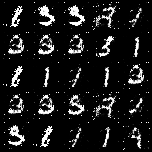

In [3]:
from IPython.display import Image

Image('92000.png')